In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [56]:
length=1000
def Majew(gamma, alpha, kappa1, beta, Lambda, stdv):
    
    Epsilon=np.random.normal(0, stdv, length)
    v=np.zeros(length)
    m=np.zeros(length)
    
    # We initialize the different functions we will need
    
    p=np.ones(length)
    
    # We initialize the price
    
    for t in range(1,length-1):
        
        v[t] = (1-Lambda)*v[t-1] + Lambda*p[t]
        
        m[t] = (1-alpha)*m[t-1] + alpha*(p[t]-p[t-1])
        
        p[t+1] = p[t] + kappa1*(v[t]-p[t]) + beta*np.tanh(gamma*m[t]) + Epsilon[t+1]
    
    return p
        
    

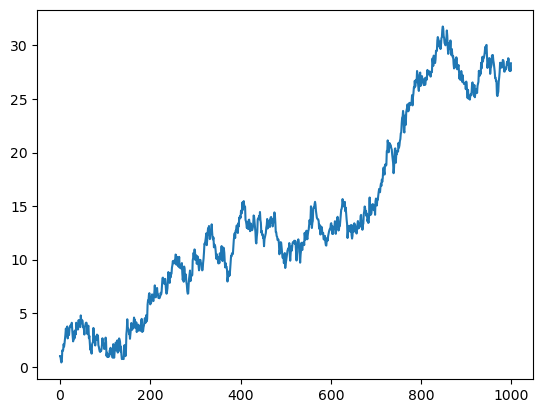

In [74]:
plt.plot(Majew(0.5,0.5,0.5,0.5,0.5,0.5))